# Missing fundamental via GrFNNs

Add explanation and references



## Stimuli

First, we synthesize the stimuli. Lets create full signal called `x_full` (i.e. with fundamental) and then progresively generate 3 missing fundamental signal by increasingly removing the lower harmonics (`x_missing1`, `x_missing2`, `x_missing3`)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(-1, 1)

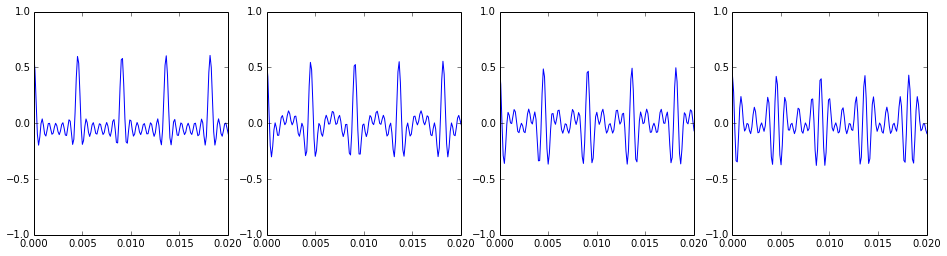

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt



fs = 8000.0
f0 = 220.0  # Hz
duration = 0.05 # 1.0

t = np.linspace(0, duration, num=fs*duration)
N_overtones = 7
harmonics = np.arange(1, N_overtones)

f = f0 * harmonics;

# exponentially decaying gain
# G = 0.5 * np.exp(-f/1e3) + 0.5
G = np.ones_like(f)

x_full = np.sum(np.exp(2j*np.pi*np.outer(f,t)), 0)/N_overtones
x_missing1 = np.sum(G[1:]*np.exp(2j*np.pi*np.outer(t, f[1:])), 1)/N_overtones
x_missing2 = np.sum(G[2:]*np.exp(2j*np.pi*np.outer(t, f[2:])), 1)/N_overtones
x_missing3 = np.sum(G[3:]*np.exp(2j*np.pi*np.outer(t, f[3:])), 1)/N_overtones

def normalize(x, g=1.0):
#     return g*x/np.max(np.abs(x))
    return g*x/np.sqrt(np.mean(x*np.conj(x)))


G = 0.25
x_full = normalize(x_full, G)
x_missing1 = normalize(x_missing1, G)
x_missing2 = normalize(x_missing2, G)
x_missing3 = normalize(x_missing3, G)


from scipy.io import wavfile


plt.figure(figsize=(16,4))

ax1 = plt.subplot(1,4,1)
plt.plot(t, np.real(x_full))

ax2 = plt.subplot(1,4,2, sharex=ax1, sharey=ax1)
plt.plot(t, np.real(x_missing1))

ax3 = plt.subplot(1,4,3, sharex=ax1, sharey=ax1)
plt.plot(t, np.real(x_missing2))

ax4 = plt.subplot(1,4,4, sharex=ax1, sharey=ax1)
plt.plot(t, np.real(x_missing3))

plt.xlim(0, 0.02)
plt.ylim(-1, 1)

_**You can listen to them here:**_

In [206]:
from IPython.display import Audio
Audio(np.real(x_full), rate=fs)

In [207]:
Audio(np.real(x_missing1), rate=fs)

In [208]:
Audio(np.real(x_missing2), rate=fs)

In [209]:
Audio(np.real(x_missing3), rate=fs)

## One GrFNN to rule them all

By configuring a single GrFNN in super-critical regime ($\alpha > 0, \beta_1 < 0$ and $\beta_2 = 0$) we can achieve that.

400/400 done!
400/400 done!
400/400 done!
400/400 done!


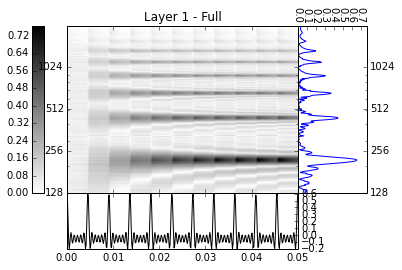

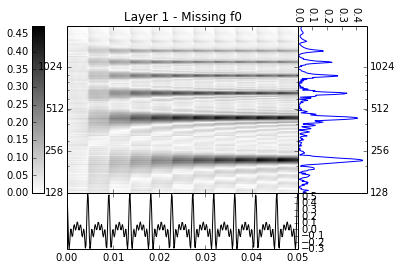

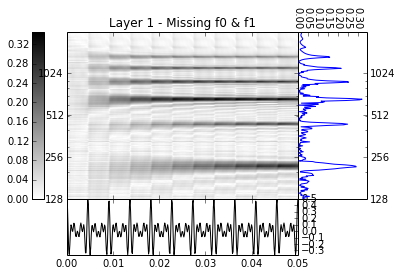

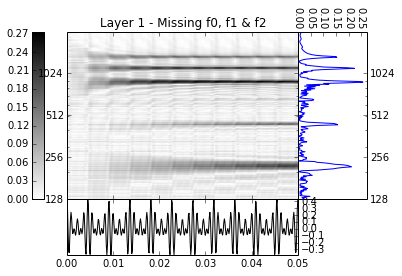

In [24]:
from pygrfnn import GrFNN
from pygrfnn.oscillator import Zparam
from pygrfnn.network import Model, make_connections
from pygrfnn.vis import tf_detail, tf_simple
from matplotlib2tikz import save as tikz_save


# supercritical
params1 = Zparam(alpha=0.0001, beta1=-1, beta2=0, epsilon=1.0)

freqs = (128, 2048)
num_oscs = 256

stimulus_conn_type = 'allfreq'
gain = 1.0

# create model
g1 = GrFNN(params1, frequency_range=freqs, num_oscs=num_oscs, stimulus_conn_type=stimulus_conn_type, w=100.0)
m = Model()
m.add_layer(g1, input_channel=0)


# C = make_connections(g1, g1, 
#                      strength=1.0, range=1.05, 
#                      modes=[1/3., 1/2., 1., 2., 3.], 
#                      mode_amplitudes =[1, 1, 1, 1, 1],
#                      self_connect=True)


# save initial states to use the same for every run
z0 = [g.z.copy() for g in m.layers()]

output_dir = '/Users/jorgeh/Documents/CCRMA/research/ismir2015/frameworkPaper/figs/missingFundamental'

for s, name, filename in [(x_full, 'Full', 'full'), 
                (x_missing1, 'Missing f0', 'missing1'), 
                (x_missing2, 'Missing f0 & f1', 'missing2'), 
                (x_missing3, 'Missing f0, f1 & f2', 'missing3')]:
    
        # reset states
    for z, l in zip(z0, m.layers()):
        l.z = z.copy()
    
    # run it
    m.run(gain*s, t, 1/fs)

    # show TFR
    tf_detail(np.abs(g1.Z), t, g1.f, t_detail=np.max(t), x=s, title="Layer 1 - {}".format(name), 
#               vmin=0, 
#               vmax=0.7
             )
    
    # NOTE: tikz_save can't handle the color bar, so if you uncomment this, you'll need to go to the source code
    # in pygrfnn.vis and comment out the line lines `cb = plt.colorbar(im, ax=axTF, cax=axCB)` and 
    # `cb.ax.yaxis.set_ticks_position('left')`
#     tikz_save('{}/{}.tikz'.format(output_dir, filename), figureheight='3cm', figurewidth='4cm')



# THE PREVIOUS CODE GENERATED THE FIGURES ADDED TO THE PAPER ON APRIL 28 NEXT CODE IS EXPERIMENTAL

(100, 2000)

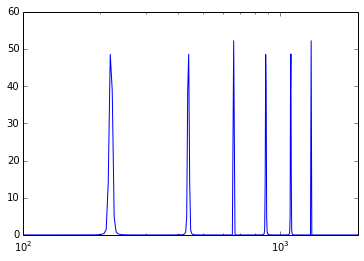

In [37]:
# FFT of the stimuli

from numpy.fft import fft

N = min(len(x_full), 2048)
x = np.real(x_full[:N])*np.hanning(N)
XF = np.abs(fft(x))

f = np.arange(0, fs, fs/N)

plt.semilogx(f[:N/2], XF[:N/2])

plt.xlim(100, 2000)




x,y
x,y
x,y
x,y


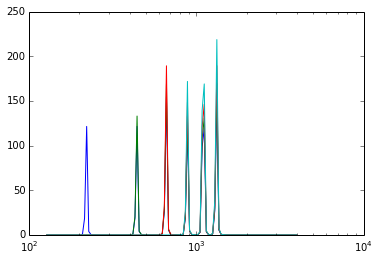

In [52]:
import librosa

fmin = 128
n_bins = 60 * 2
bins_per_octave=12 * 2

cqtF = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)

for s in [x_full, x_missing1, x_missing2, x_missing3]:
    C = librosa.cqt(np.real(s), sr=fs, fmin=fmin,
                    n_bins=n_bins, bins_per_octave=bins_per_octave)[:,-1]    
    plt.semilogx(cqtF, C)
    print 'x,y'
#     for x,y in zip(cqtF, C):
#         print '{},{}'.format(x, y)
#     print '\n\n'

(-0.2, 0.9)

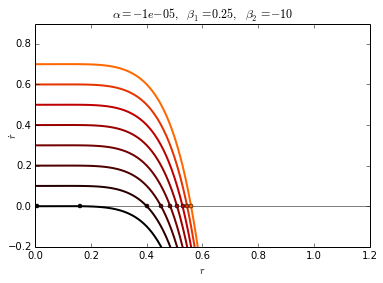

In [2]:
from pygrfnn import GrFNN
from pygrfnn.oscillator import Zparam
from pygrfnn.network import Model, make_connections
from pygrfnn.vis import tf_detail, tf_simple, vector_field
from matplotlib2tikz import save as tikz_save


# supercritical
# params1 = Zparam(alpha=0.0001, beta1=-1, beta2=-1, epsilon=1.0)  # this kind of works without 'w' and gain=0.4
params1 = Zparam(alpha=-0.00001, beta1=.25, beta2=-10, epsilon=0.95)

vector_field(alpha=params1.alpha, 
             beta1=params1.beta1, 
             beta2=params1.beta2, 
             delta1=params1.delta1, delta2=params1.delta2, 
             epsilon=params1.epsilon, 
             F=np.arange(0,0.8, 0.1))

plt.ylim(-.2,.9)

400/400 done!
400/400 done!
400/400 done!
400/400

/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python2.7/site-packages/matplotlib/image.py:349: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


 done!


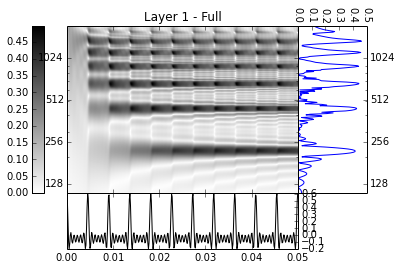

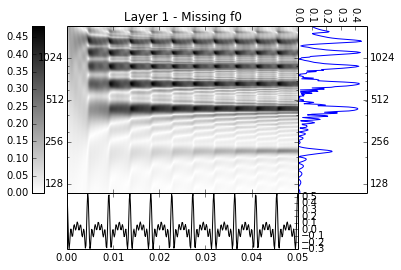

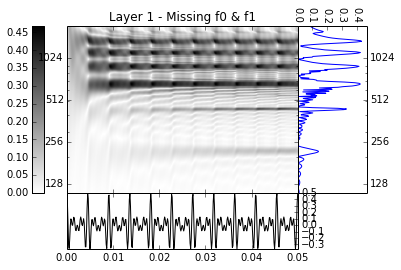

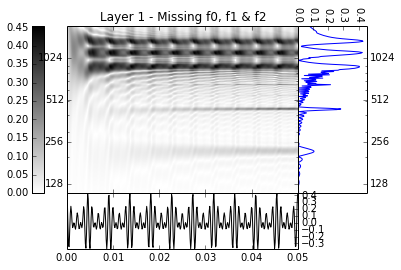

In [3]:
N_octaves = 4
freqs = (110, 110*2**N_octaves)
num_oscs = 64*N_octaves

stimulus_conn_type = 'allfreq'
gain = 0.5

# create model
g1 = GrFNN(params1, 
           z0 = 0,
           frequency_range=freqs, 
           num_oscs=num_oscs, 
           stimulus_conn_type=stimulus_conn_type, 
#            w=100.0
          )
m = Model()
m.add_layer(g1, input_channel=0)

# save initial states to use the same for every run
z0 = [g.z.copy() for g in m.layers()]

output_dir = '/Users/jorgeh/Documents/CCRMA/research/ismir2015/frameworkPaper/figs/missingFundamental'


mean_10ms = {}

for s, name, filename in [(x_full, 'Full', 'full'), 
                (x_missing1, 'Missing f0', 'missing1'), 
                (x_missing2, 'Missing f0 & f1', 'missing2'), 
                (x_missing3, 'Missing f0, f1 & f2', 'missing3')]:
    
    # reset states
    for z, l in zip(z0, m.layers()):
        l.z = z.copy()
    
    # run it
    m.run(gain*s, t, 1/fs)

    # show TFR
    tf_detail(np.abs(g1.Z), t, g1.f, t_detail=np.max(t), x=s, title="Layer 1 - {}".format(name), 
#               vmin=0, 
#               vmax=0.7
             )
    
    M = int(20e-3*fs)
    mean_10ms[name] = np.mean(np.abs(g1.Z[:,-M:]),1)
    
    
    # NOTE: tikz_save can't handle the color bar, so if you uncomment this, you'll need to go to the source code
    # in pygrfnn.vis and comment out the line lines `cb = plt.colorbar(im, ax=axTF, cax=axCB)` and 
    # `cb.ax.yaxis.set_ticks_position('left')`
#     tikz_save('{}/{}.tikz'.format(output_dir, filename), figureheight='3cm', figurewidth='4cm')

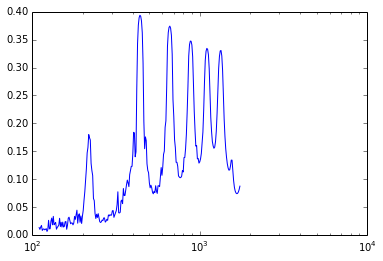

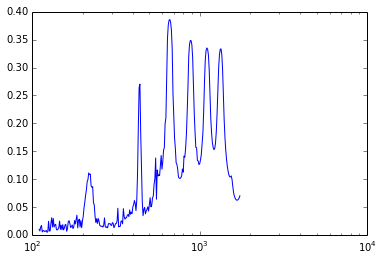

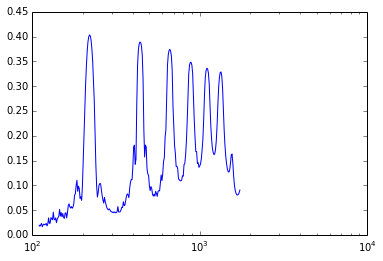

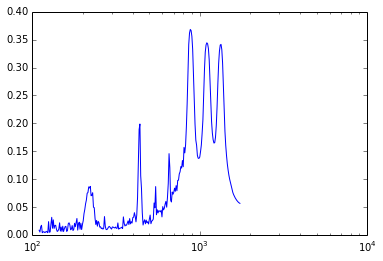

In [328]:
for m in mean_10ms:
    plt.figure()
    plt.semilogx(g1.f, mean_10ms[m])